# Tubes a choc

In [1]:
from trustutils import run

run.introduction('Y. GORSSE, M. NDJINGA')

## Introduction 
 Validation made by : Y. GORSSE, M. NDJINGA



 Report generated 04/02/2022

### Description 
Issus du chapitre 10 du livre de Eleuterio F. Toro, Riemann Solvers and Numerical Methods for Fluid Dynamics, Third edition, Springer, 2009. 

Couramment utilisés comme benchmark pour le comportement de        méthodes numériques dans les ouvrages et publications scientifiques, ainsi que pour la vérification du comportement de certains codes.

Objectifs : montrer la la robutesse du code et évaluer 

1. l'apparition d'oscillations parasites, 
2. la propagation des ondes avec la bonne vitesse, 
3. la capture des états intermédiaires à la bonne hauteur.

In [2]:
run.TRUST_parameters()

### TRUST parameters 
 * Version TRUST: 1.8.4
 * Binary used: /export/home/adrien/Projets/TRUST/TRUST_LOCAL/exec/TRUST_mpi_opt (built on TRUST /export/home/adrien/Projets/TRUST/TRUST_LOCAL/Validation/Rapports_automatiques/Verification/Multiphase/tubes_a_choc/build)

In [3]:
from trustutils import run, plot
import os

run.defaultSuite_ = run.TRUSTSuite(runPrepare=False)

origin, build_dir = os.getcwd(), run.defaultSuite_.getBuildDirectory()
os.chdir(build_dir)
exec(open("main.py").read())
os.chdir(origin)

list_meshes = [100, 800]
list_tests = ['Toro1','Toro2','Toro4','Toro5','Toro6','Toro7','PWR1','PWR2','PWR3']

for m in list_meshes:
    for test in list_tests:
        run.addCase("n%d" %m,'%s.data'%test)

run.printCases()
run.runCases()

### Test cases 
* n100/Toro1.data : 
* n100/Toro2.data : 
* n100/Toro4.data : 
* n100/Toro5.data : 
* n100/Toro6.data : 
* n100/Toro7.data : 
* n100/PWR1.data : 
* n100/PWR2.data : 
* n100/PWR3.data : 
* n800/Toro1.data : 
* n800/Toro2.data : 
* n800/Toro4.data : 
* n800/Toro5.data : 
* n800/Toro6.data : 
* n800/Toro7.data : 
* n800/PWR1.data : 
* n800/PWR2.data : 
* n800/PWR3.data : 


Running **with Sserver**...
  => A total of 18 cases were (successfully) run in 22.5s.


## Description des cas tests

These tests are designed to assess the robustness and accuracy of numerical methods at the core of the solver, independently from the boundary condition, and source term treatment involving correla       tions.

They consist in the numerical resolution of the Shock tube problem for a perfect gas with $\gamma=1.4$. 

The initial state consists in two constant states $W_L=(\rho_L,u_L,p_L)$ and $W_R=(\rho_R,u_R,p_R)$ separated by a discontinuity at $x=x_d$. The following table gives the values of $W_L$ and $W_R$ for each test.

In [4]:
tab.df

,$\gamma$,$p_\infty$,$\rho_L$,$u_L$,$p_L$,$\rho_R$,$u_R$,$p_R$,$x_d$
Toro1,1.40,0,1,0.7500,1,0.12500,0,1.000000e-01,0.3
Toro2,1.40,0,1,-2.0000,0.4,1.00000,2,4.000000e-01,0.5
Toro3,1.40,0,1,0.0000,1000,1.00000,0,1.000000e-02,0.5
Toro4,1.40,0,5.99924,19.5975,460.894,5.99242,-6.19633,4.609500e+01,0.4
Toro5,1.40,0,1,-19.5975,1000,1.00000,-19.59745,1.000000e-02,0.8
Toro6,1.40,0,1.4,0.0000,1,1.40000,0,1.000000e+00,0.5
Toro7,1.40,0,1.4,0.1000,1,1.00000,0.1,1.000000e+00,0.5
PWR1,1.58,353637173.0,700,0.0000,15500000.0,700.00000,0,1.000000e+05,0.5
PWR2,1.58,353637173.0,700,0.0000,15500000.0,700.00000,20,1.550000e+07,0.5
PWR3,1.58,353637173.0,700,0.0000,15500000.0,650.00000,0,1.550000e+07,0.5


## Cas test Toro1

## Cas test Toro2

## Cas test Toro4

## Cas test Toro5

## Cas test Toro6

## Cas test Toro7

## Cas test PWR1

## Cas test PWR2

## Cas test PWR3

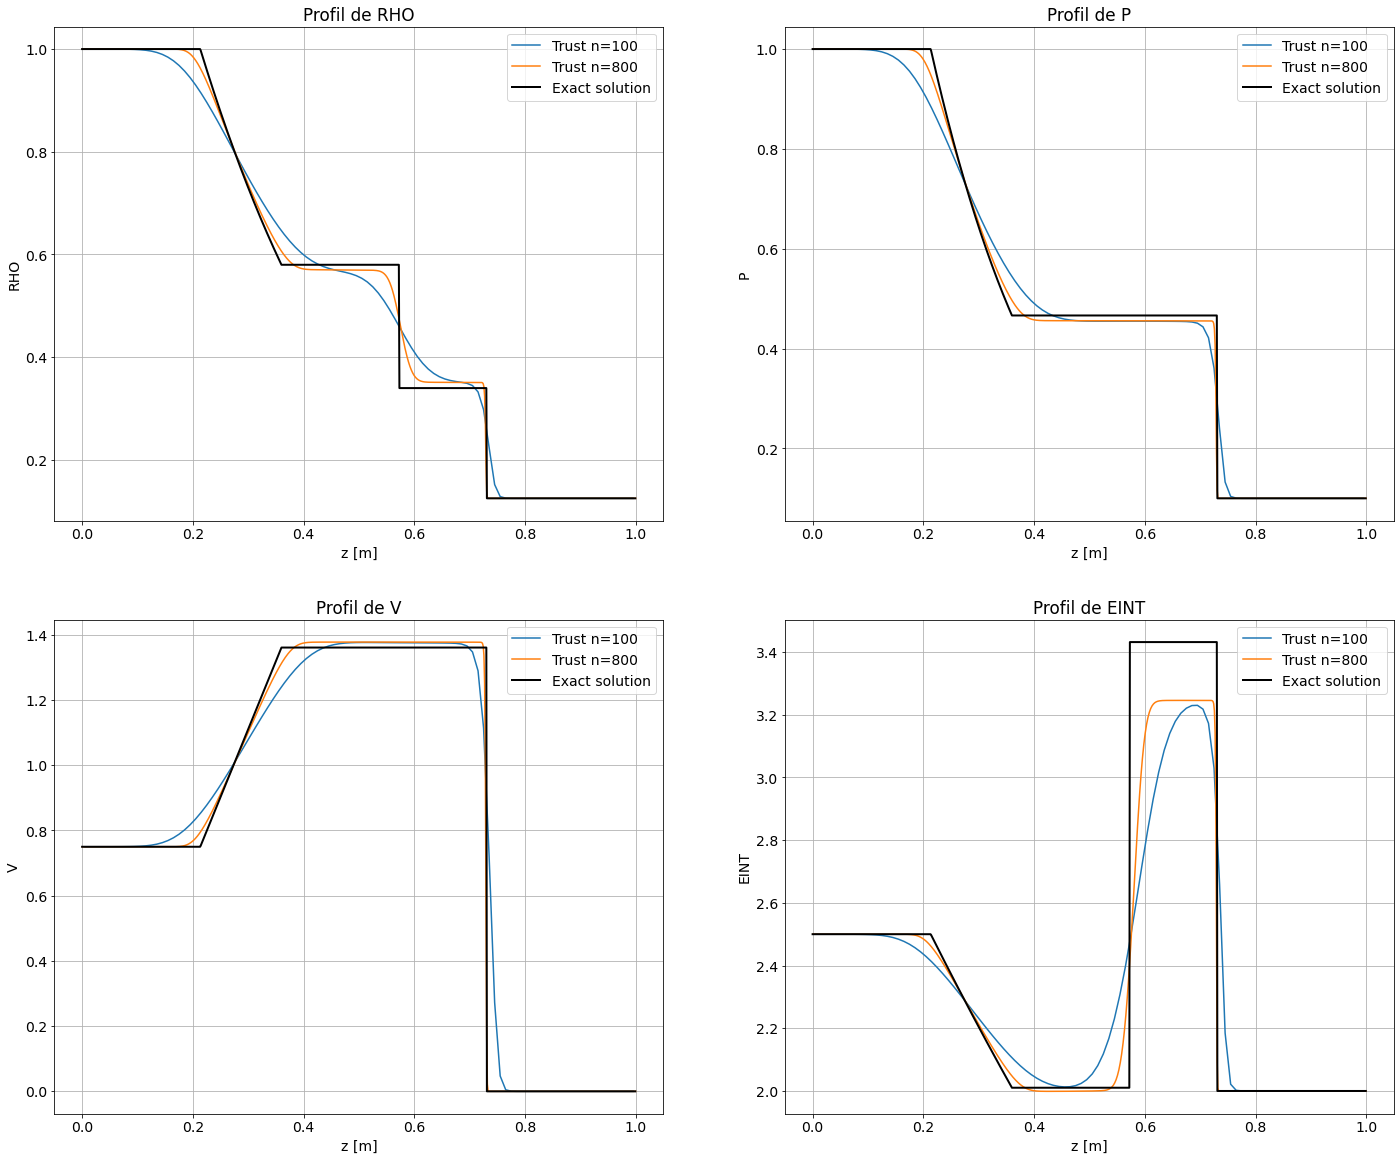

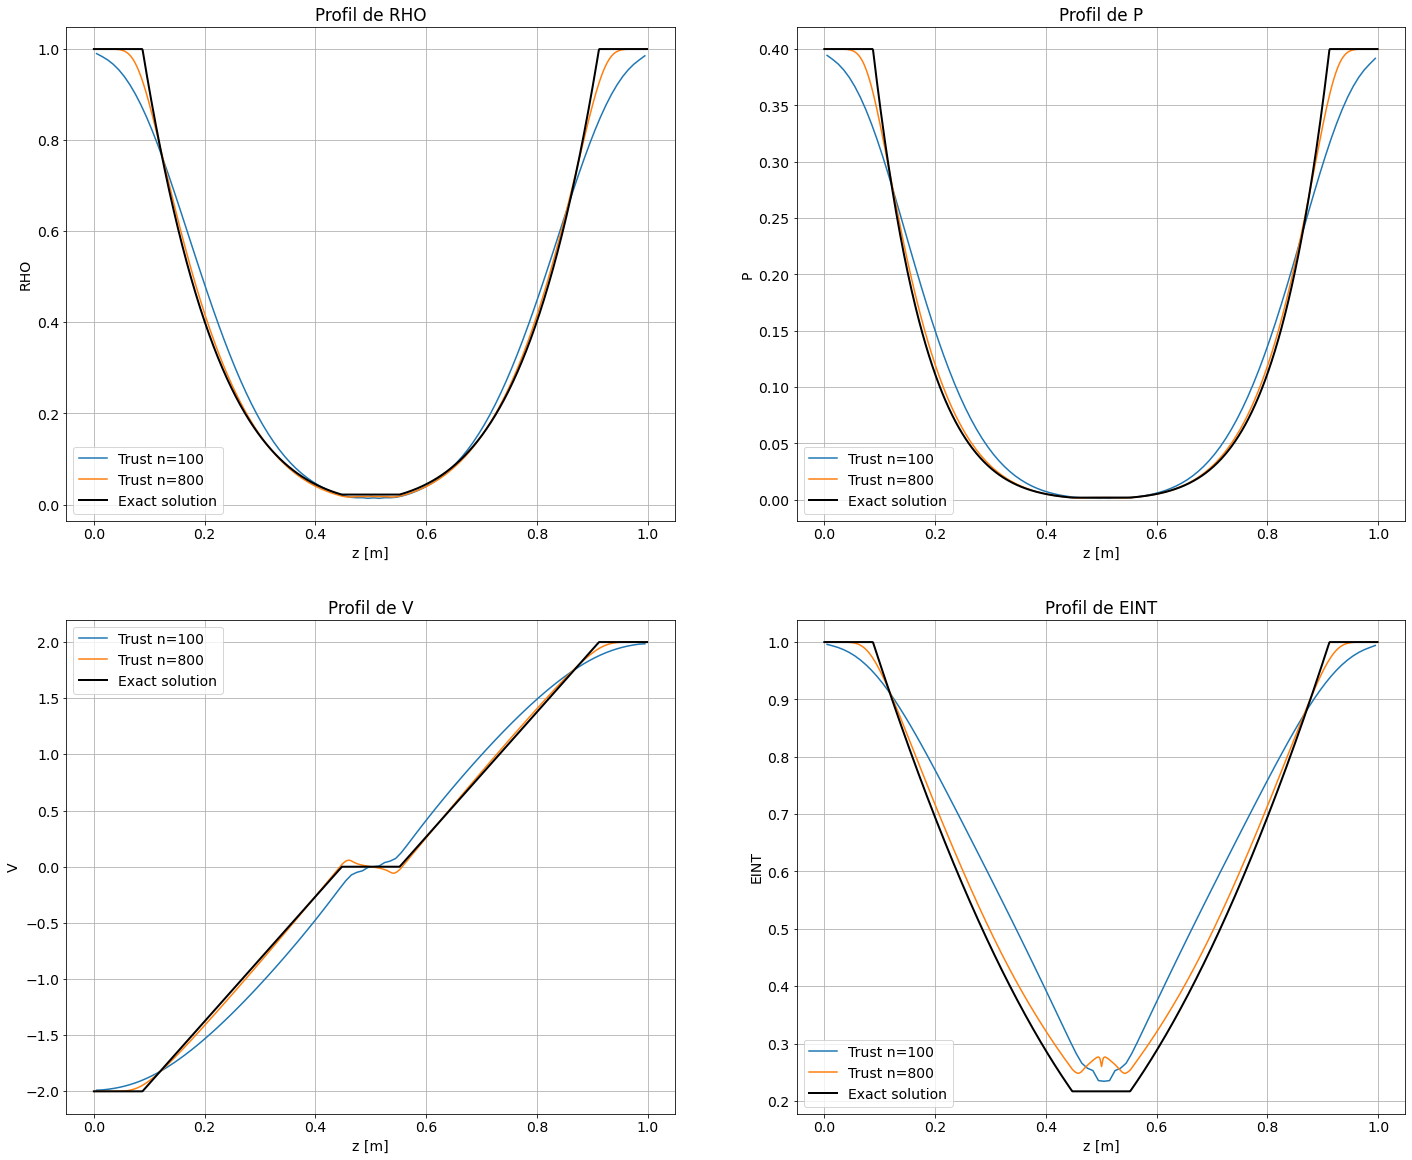

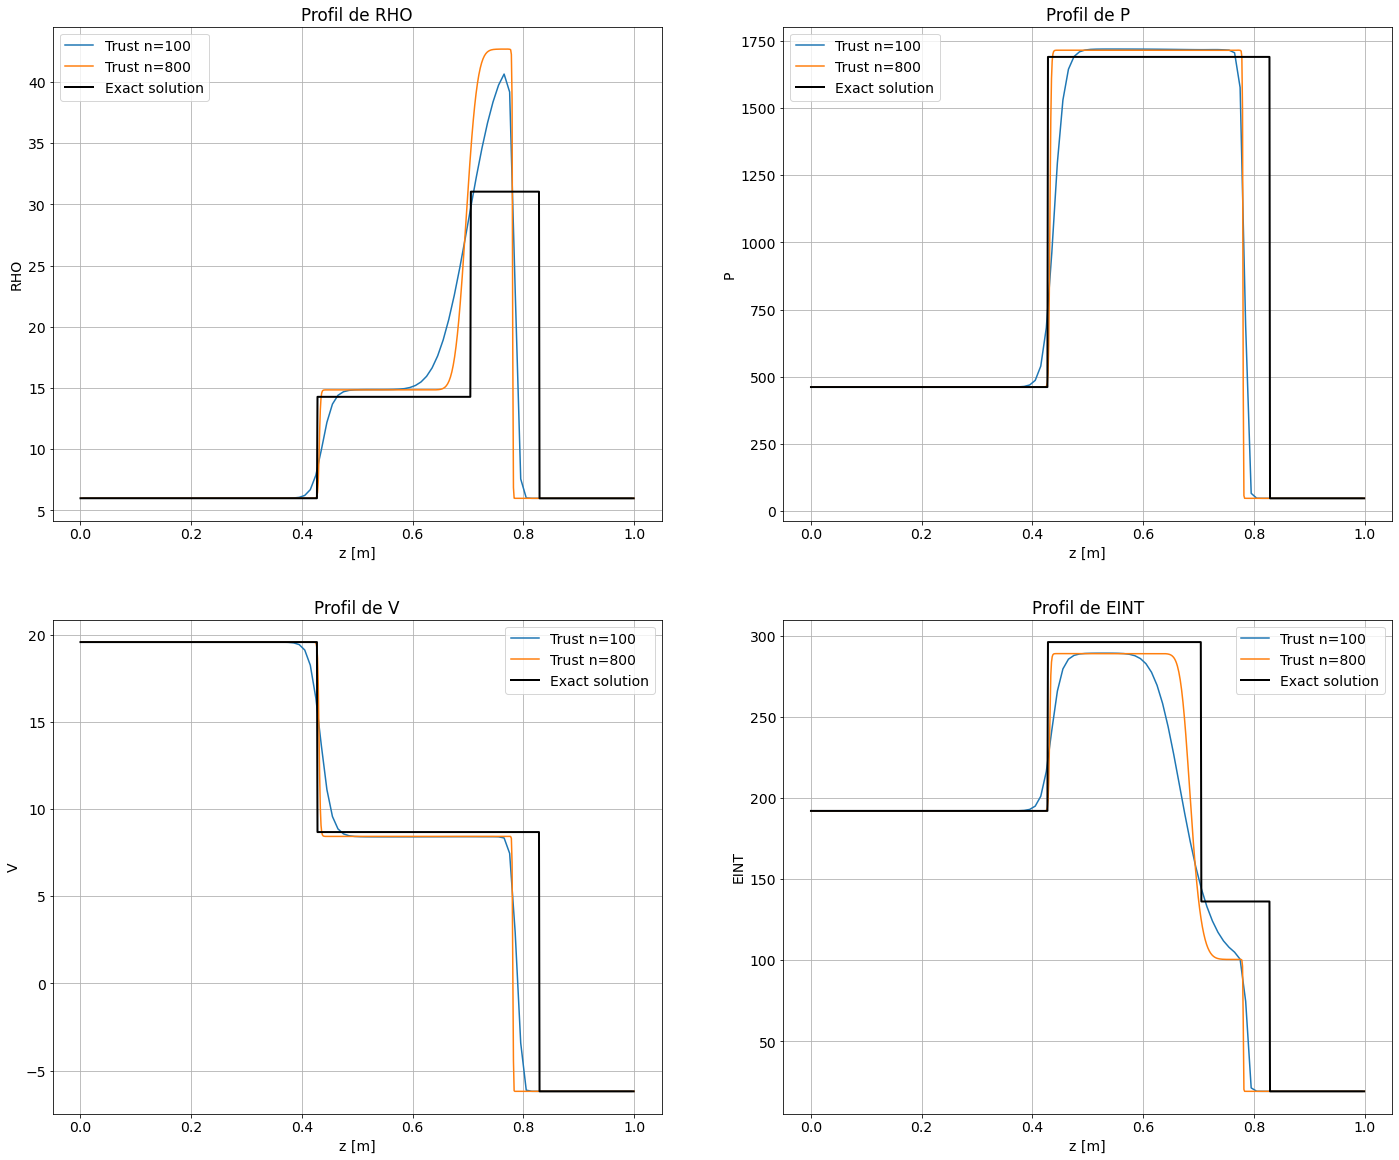

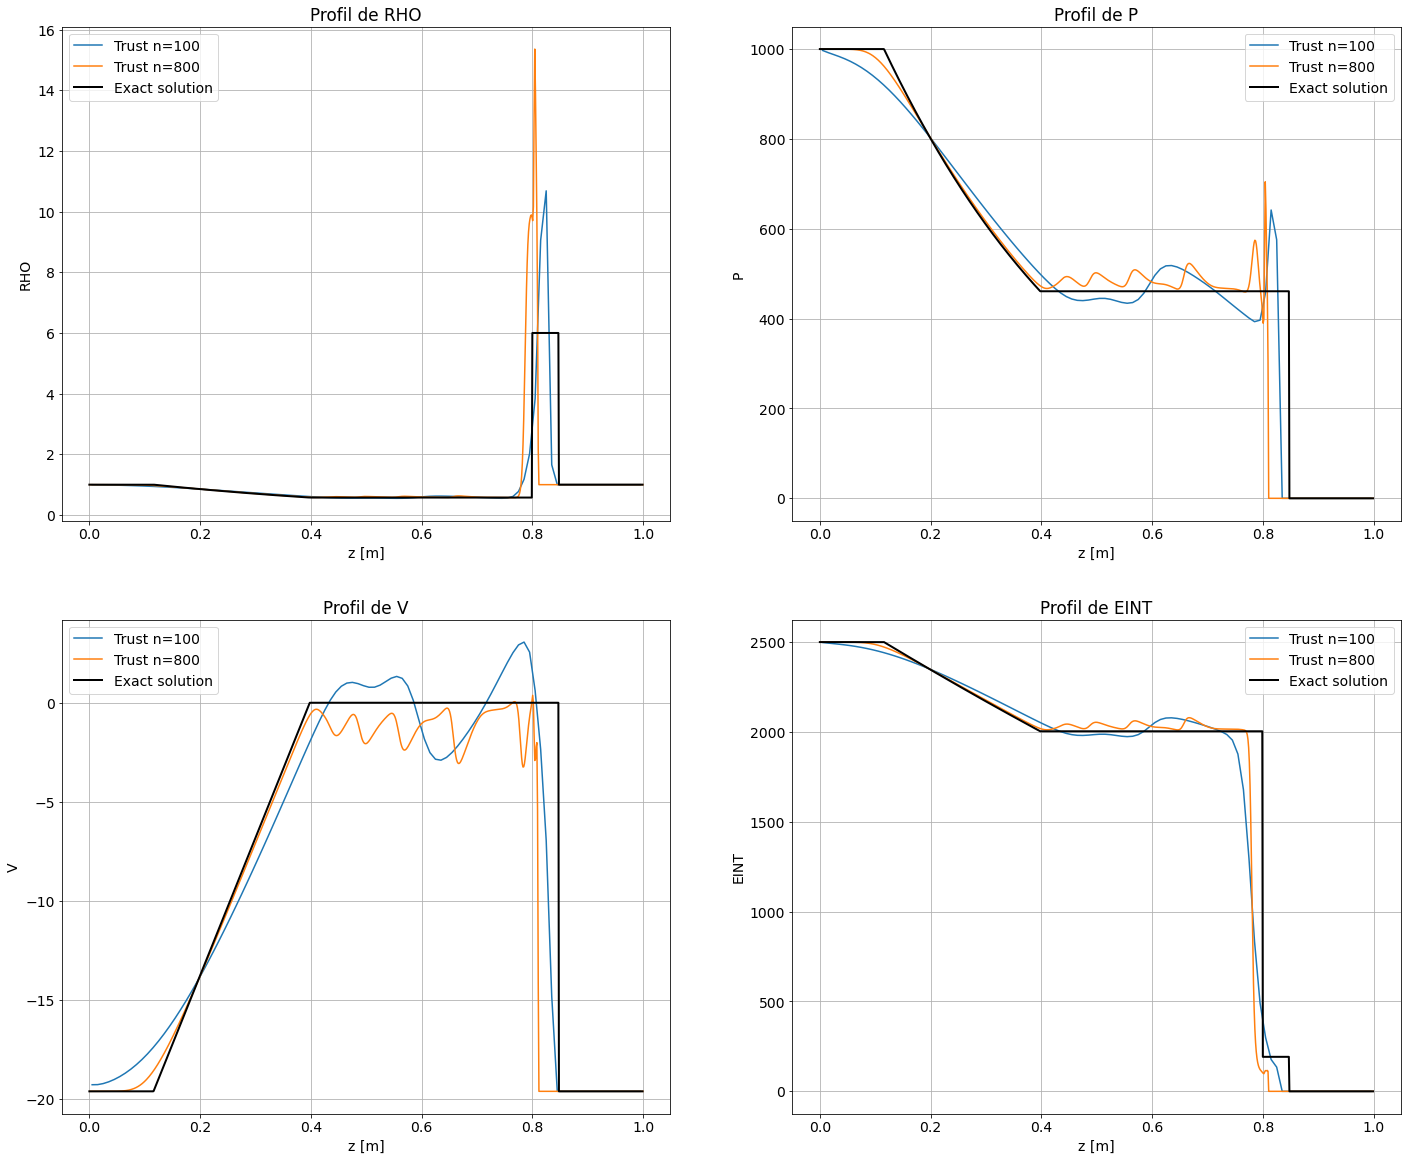

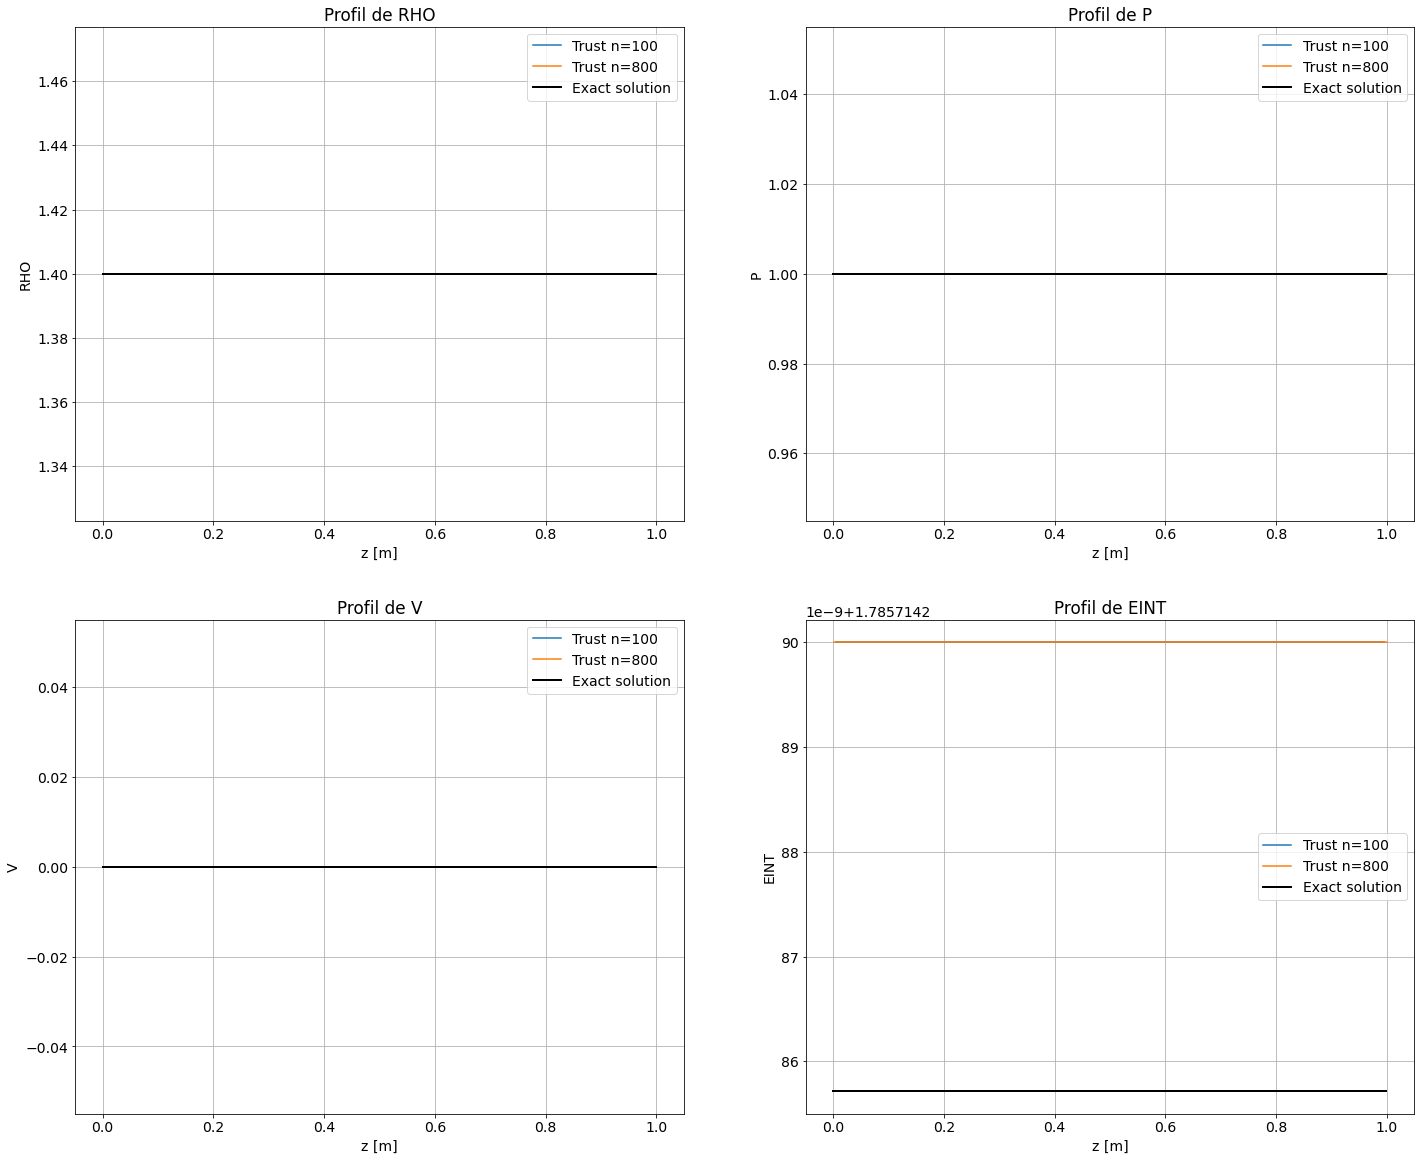

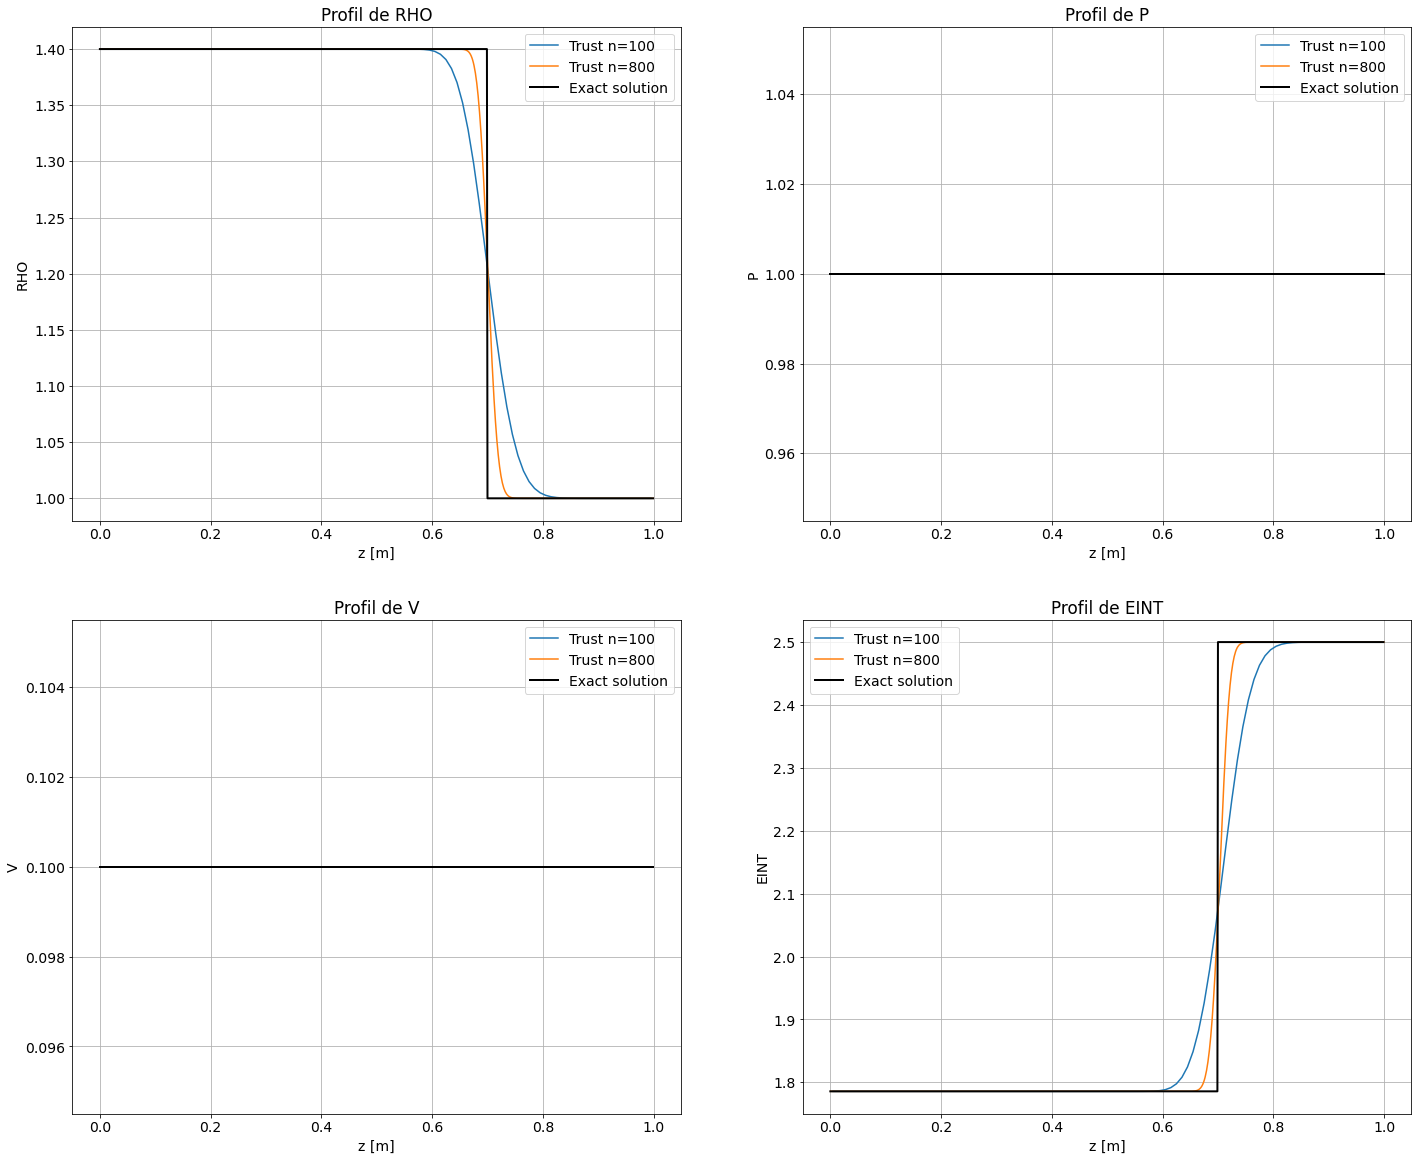

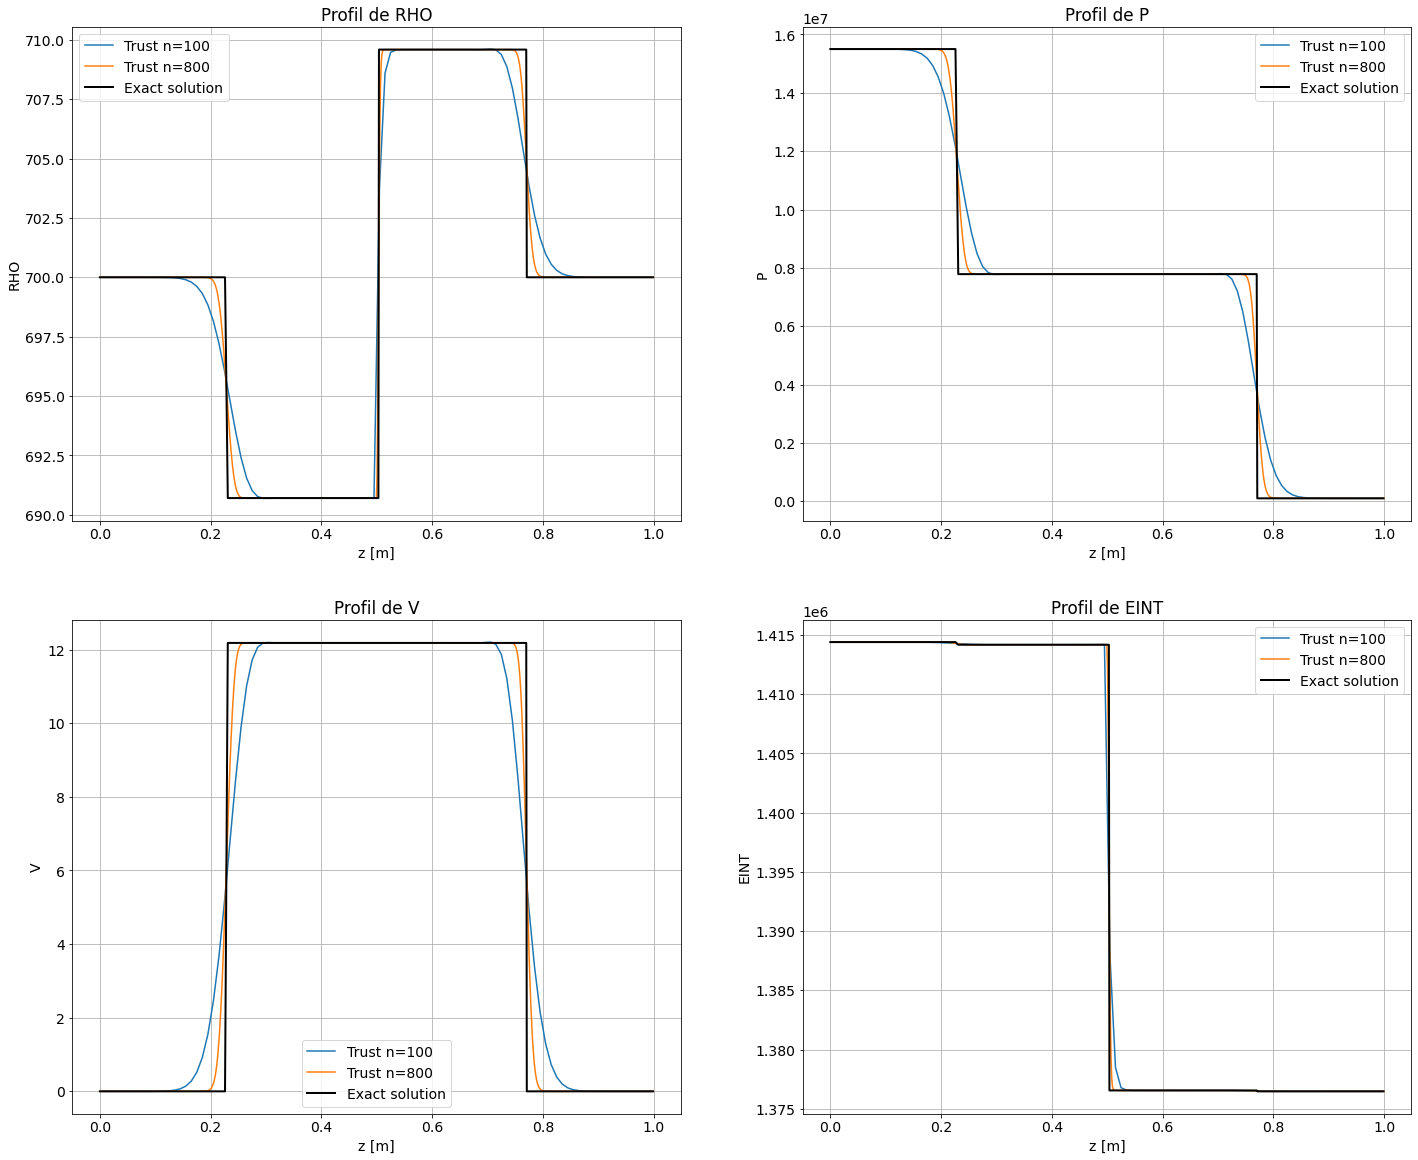

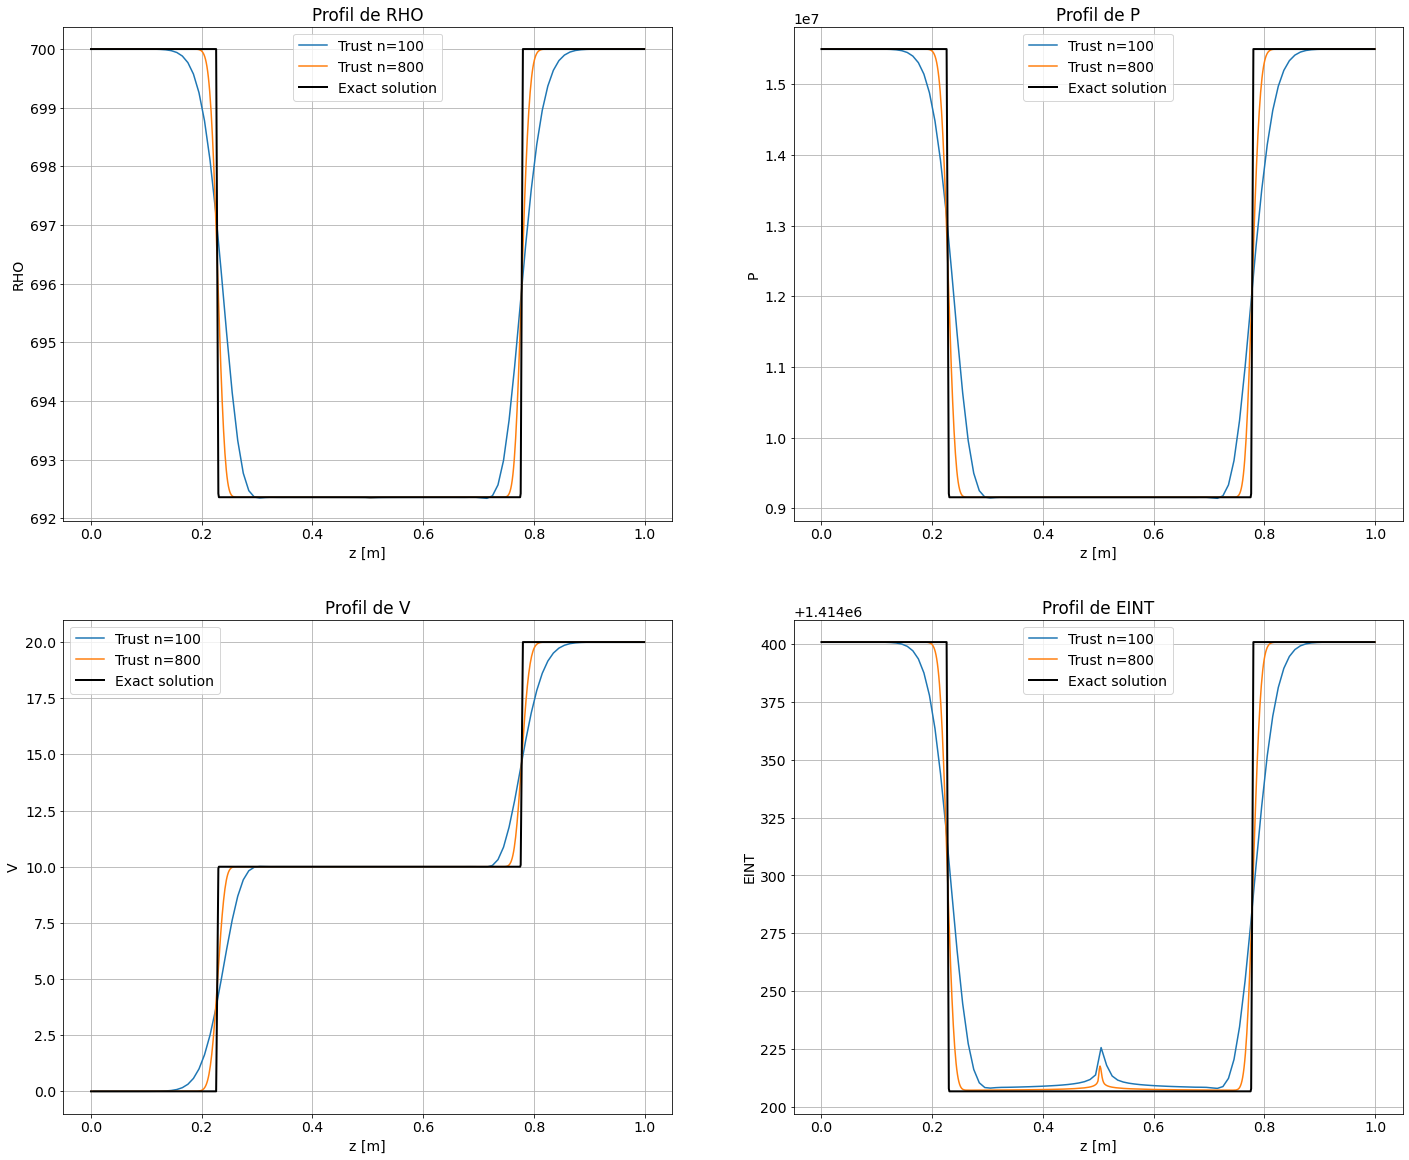

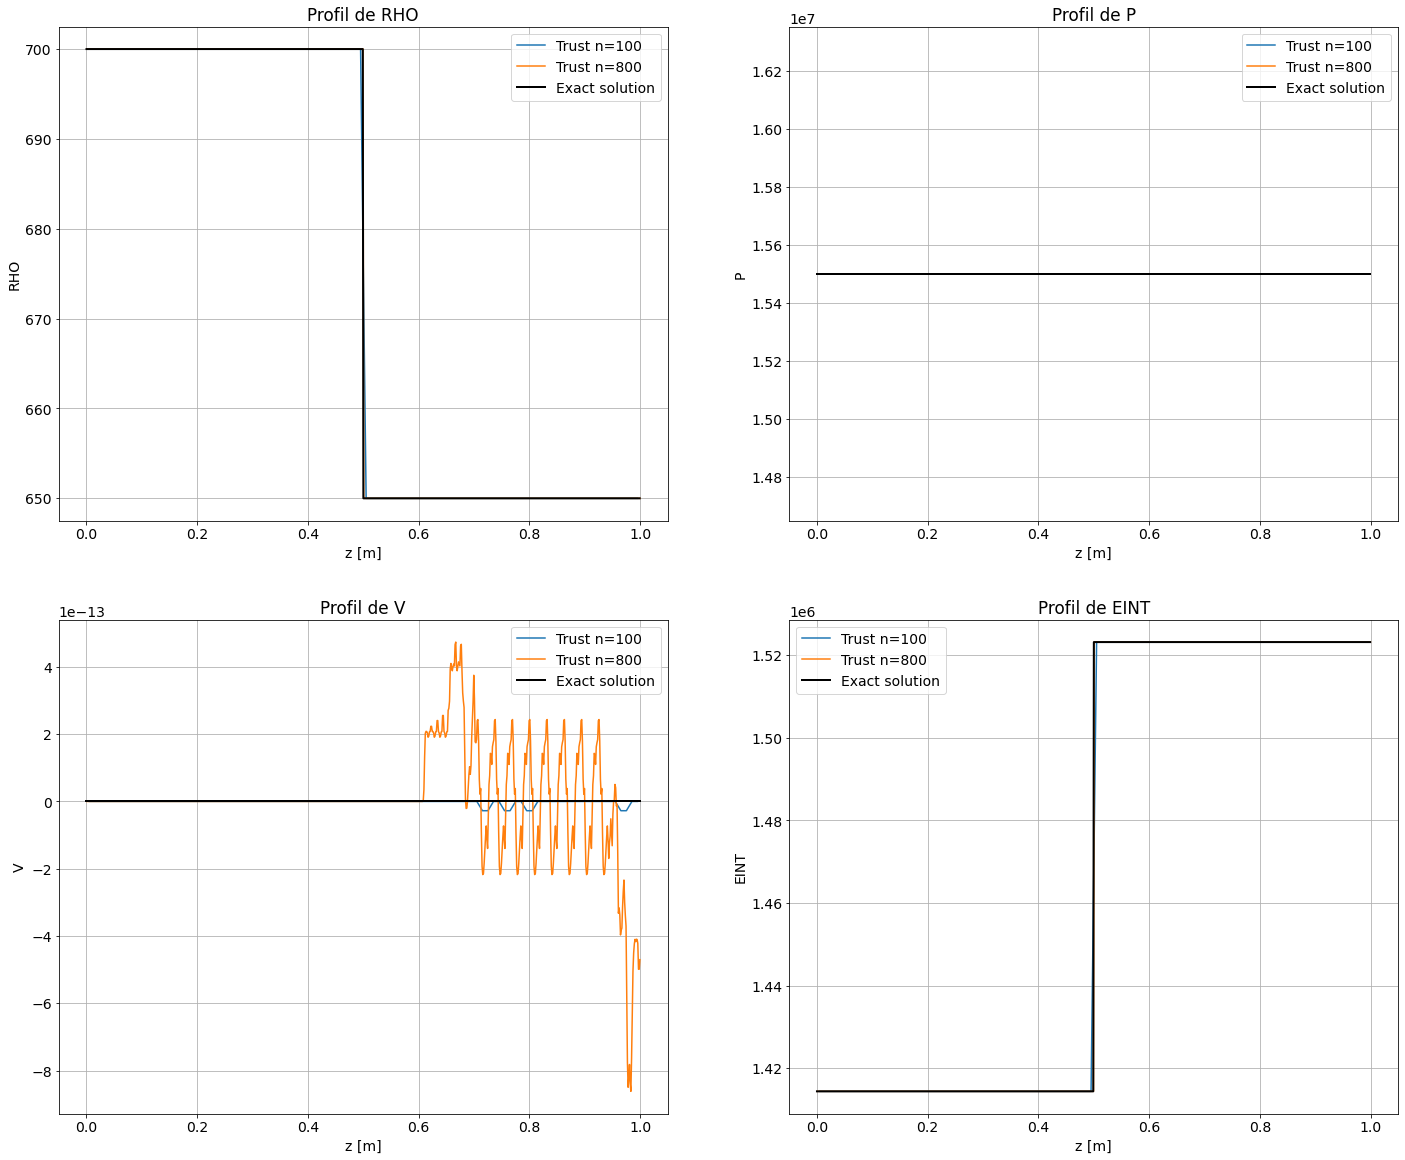

In [5]:
import time

variables = ["RHO", "P", "V", "EINT"]

for test in list_tests:
    run.displayMD("## Cas test %s" %test)
    
    columns = plot.readFile("%s.ex"%test)
    var = columns[0].split()
    data = plot.loadText("%s.ex"%test,skiprows=1)
    
    a = plot.Graph(nX=2,nY=2)
    nX = 0
    nY = 0
    for p in variables:
        a.addPlot([nX,nY],"Profil de %s" %p)
        for m in list_meshes:
            a.addSegment("n%d/%s_%s.son"%(m,test,p),label="Trust n=%d"%m)
        nb = var.index(p)
        a.add(data[0],data[nb],label="Exact solution",lw=2,color='k')
        a.label("z [m]","%s" %p)
        
        if (nY == 1):
            nY = 0
            nX +=1
        else:
            nY +=1